In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import einops
import os

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4070 SUPER'

In [3]:
from datasets import load_dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split

if os.path.exists("latents_vector.npy"):
    ds = load_dataset("Artificio/WikiArt_Full", keep_in_memory=False).with_format('torch')
    print(ds)
    # normalize = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    train_loader = DataLoader(
            ds["train"],
            batch_size=32,
            num_workers=16,
            shuffle=False
        )

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 103250
    })
})


In [5]:
from models import Encoder, Decoder, AutoEncoder

latent_width = 1024
encoder = Encoder(latent_width)
encoder.load_state_dict(torch.load("models/encoder_9.pth"))
decoder = Decoder(encoder.latent_width)
decoder.load_state_dict(torch.load("models/decoder_9.pth"))
model = AutoEncoder(encoder, decoder)
model.load_state_dict(torch.load("models/model_9.pth"))

C:\Users\Dominik\AppData\Local\Temp\ipykernel_12716\825285906.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("models/encoder_9.pth"))

<All keys matched successfully>

In [7]:
from tqdm import tqdm
if not os.path.exists("latents_vector.npy"):
    latents_vector = list()
    encoder = model.encoder
    encoder = encoder.cuda()
    for i in tqdm(train_loader):
        images = i["image"] / 255.0
        for x in images:
            x = x.cuda()
            latent = encoder(x.unsqueeze(0))
            latent = latent.detach().cpu().numpy()
            latents_vector.append(latent)


100%|██████████| 3227/3227 [02:54<00:00, 18.53it/s]


In [8]:
import numpy as np

if not os.path.exists("latents_vector.npy"):
    latents_vector = np.array(latents_vector)
    np.save("latents_vector",latents_vector)



In [8]:
import numpy as np

latents_vector = []
latents_vector = np.load("latents_vector.npy")
print(latents_vector.shape)
latents_vector = latents_vector.reshape(102217, 1024)
print(latents_vector.shape)

(102217, 1, 1024)
(102217, 1024)


In [17]:
transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((256, 256)),
])

def preprocess(example):
    example['image'] = example['image'].float() / 255.0
    example['image'] = transform(example['image'])
    return example

gmm_labels = []
gmm_labels = np.load("labels.npy")

ds = load_dataset("Artificio/WikiArt_Full").with_format('torch')

c:\Users\Dominik\anaconda3\envs\cuda_env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from collections import Counter

n_components_pca = 600
pca = PCA(n_components=n_components_pca, random_state=42)
reduced_latents_pca = pca.fit_transform(latents_vector)

n_clusters = 10
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(reduced_latents_pca)
np.save('labels.npy', gmm_labels)
    
label_counts = Counter(gmm_labels)
print("Cluster Label Counts (Gaussian Mixture):")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count}")

Cluster Label Counts (Gaussian Mixture):
Label 0: 15475
Label 1: 8873
Label 2: 6878
Label 3: 11572
Label 4: 6462
Label 5: 11851
Label 6: 6380
Label 7: 10429
Label 8: 9875
Label 9: 15455


c:\Users\Dominik\anaconda3\envs\cuda_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


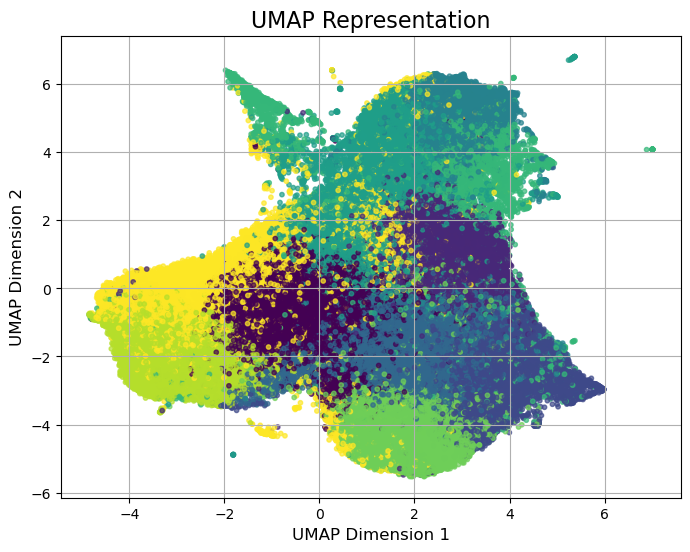

In [32]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
umap_representation = reducer.fit_transform(latents_vector)

plt.figure(figsize=(8, 6))
plt.scatter(umap_representation[:, 0], umap_representation[:, 1], s=10, c=gmm_labels, alpha=0.7)
plt.title("UMAP Representation", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True)
plt.show()